In [1]:
# 기본 패키지 설치
!pip install numpy pandas matplotlib

# nltk
!pip install nltk
# Gensim 및 의존 패키지 설치
!pip install gensim

# spaCy 및 언어 모델 설치
!pip install spacy
!python -m spacy download en_core_web_sm

# 시각화 툴 설치 (pyLDAvis)
!pip install pyLDAvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 1.8 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
## basic
import re
import numpy as np
import pandas as pd
from pprint import pprint

## nltk
import nltk
nltk.download('stopwords')

## Mallet
# import os 
# from gensim.models.wrappers import LdaMallet

# os.environ['MALLET_HOME'] = '/home/lhshrk/py-TopicModeling/Mallet'

## Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

/home/lhshrk/.pyenv/versions/anaconda3-2022.10/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
[nltk_data] Downloading package stopwords to /home/lhshrk/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
rawdata = pd.read_csv('/home/lhshrk/bim_gis_integration_LDA_analysis/data/dataset_final_20250224.csv', encoding='utf-8')
documents = pd.DataFrame(rawdata)
documents.head()
len(documents)

409

In [19]:
import re
import numpy as np
import pandas as pd
import nltk
import gensim
import spacy
from gensim.utils import simple_preprocess
from gensim.models import Phrases
from nltk.corpus import stopwords
from pprint import pprint

# nltk 불용어 다운로드
nltk.download('stopwords')

# 텍스트 전처리 (소문자 변환)
documents['whole_lower'] = documents['whole'].str.lower()

data = documents['whole_lower'].dropna().values.tolist()

# 불용어 설정
stop_words = stopwords.words('english')
stop_words.extend(['keynote', 'paper', 'buildingsmart', 'iso', 'ogc', 'analysis', 'example', 'research', 'report', 'approach', 'result', 'trend', 'trends', 'from', 'subject', 're', 'edu', 'use', 'early', 'current', 'late', 'korean', 'korea'])

# 텍스트 클리닝
data = [re.sub(r'\S*@\S*\s?', '', sent) for sent in data]  # 이메일 제거
data = [re.sub(r'\s+', ' ', sent) for sent in data]  # 공백 정리
data = [re.sub(r"'", "", sent) for sent in data]  # 따옴표 제거

# 토큰화
def sent_to_words(sentences):
    return [simple_preprocess(str(sentence), deacc=True) for sentence in sentences]

data_words = sent_to_words(data)

# Bigram 및 Trigram 모델
bigram = Phrases(data_words, min_count=5, threshold=100)
trigram = Phrases(bigram[data_words], threshold=100)

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# 불용어 제거 및 n-gram 적용
def process_words(texts):
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    return texts

data_words_processed = process_words(data_words)

# Lemmatization (표제어 추출)
nlp = spacy.load('en_core_web_md', disable=['parser', 'ner'])

def lemmatization(texts):
    return [[token.lemma_ for token in nlp(' '.join(doc)) if token.pos_ in ['NOUN', 'ADJ', 'VERB', 'ADV']] for doc in texts]

data_lemmatized = lemmatization(data_words_processed)

# 결과 확인
pprint(data_lemmatized[:1])


[nltk_data] Downloading package stopwords to /home/lhshrk/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[['bim',
  'technical',
  'keynote',
  'conference',
  'give',
  'overview',
  'standard',
  'effort',
  'bim',
  'context',
  'motivation',
  'strengthen',
  'general',
  'awareness',
  'promote',
  'technical',
  'tr',
  'tr',
  'academia',
  'professional',
  'engineer',
  'tr',
  'develop',
  'present',
  'discuss',
  'detail',
  'identify',
  'barrier',
  'opportunity',
  'suggest',
  'specific',
  'standard',
  'effort',
  'result',
  'tr',
  'relate',
  'standard',
  'mathematical',
  'foundation',
  'software',
  'product',
  'tr',
  'show',
  'diverse',
  'standard',
  'effort',
  'datum',
  'structure',
  'service',
  'content',
  'process',
  'come',
  'digital_twin',
  'built_environment',
  'conclusion',
  'future',
  'anticipate',
  'need',
  'standard',
  'shortly',
  'present',
  'practical',
  'example']]


Number of Topics: 6, Coherence Score: 0.3357
Number of Topics: 7, Coherence Score: 0.3395
Number of Topics: 8, Coherence Score: 0.3489
Optimal Number of Topics: 8


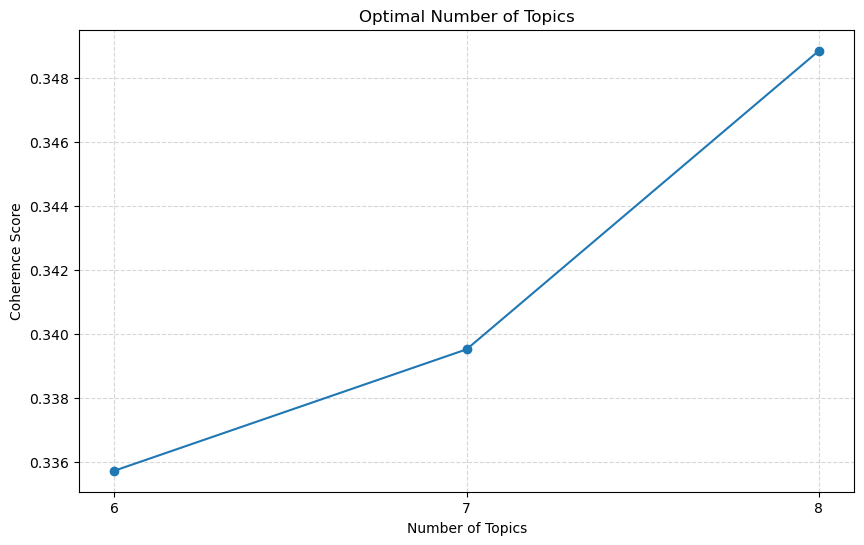

In [26]:
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import LdaModel
import matplotlib.pyplot as plt
import gensim.corpora as corpora
import numpy as np
from collections import Counter
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

# LDA 수행 전 corpus 및 dictionary 생성
id2word = corpora.Dictionary(data_lemmatized)
corpus = [id2word.doc2bow(text) for text in data_lemmatized]

# 최적 토픽 수 선정
min_topics, max_topics = 6, 8
coherence_scores = []

# 우선 괜찮음 topics scope: 2~10까지하면
# for num_topics in range(min_topics, max_topics + 1):
#     model = LdaModel(
#         corpus=corpus, 
#         num_topics=num_topics, 
#         id2word=id2word,
#         random_state=100,
#         chunksize=300,
#         passes=40,
#         iterations=600,
#         alpha='symmetric',
#         eta='auto',
#         minimum_probability=0.05,
#         gamma_threshold=0.01
#         # passes와 iterations를 높히면 중간 값(8)이 올라감
#     )

for num_topics in range(min_topics, max_topics + 1):
    model = LdaModel(
        corpus=corpus, 
        num_topics=num_topics, 
        id2word=id2word,
        random_state=100,
        chunksize=300,
        passes=10,
        iterations=800,
        alpha=0.1,
        eta=0.05,
        minimum_probability=0.005,
        gamma_threshold=0.01
        # passes와 iterations를 높히면 중간 값(8)이 올라감
    )
    coherence_model = CoherenceModel(model=model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    coherence_scores.append(coherence_score)
    print(f'Number of Topics: {num_topics}, Coherence Score: {coherence_score:.4f}')

# 최적 토픽 수 결정
optimal_topics = coherence_scores.index(max(coherence_scores)) + min_topics
print(f'Optimal Number of Topics: {optimal_topics}')

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(range(min_topics, max_topics + 1), coherence_scores, marker='o')
plt.xticks(range(min_topics, max_topics + 1))
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title('Optimal Number of Topics')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

Topic 0:  ['datum', 'model', 'national', 'information', 'traffic', 'land', 'utility', 'digital', 'integration', 'network']
Topic 1:  ['management', 'bim', 'system', 'base', 'facility', 'information', 'datum', 'maintenance', 'study', 'visualization']
Topic 2:  ['model', 'information', 'building', 'bim', 'datum', 'study', 'use', 'technology', 'base', 'build']
Topic 3:  ['city', 'smart', 'urban', 'information', 'datum', 'service', 'study', 'spatial', 'model', 'different']
Topic 4:  ['model', 'bim', 'datum', 'information', 'ifc', 'use', 'spatial', 'base', 'building', 'study']
Topic 5:  ['technology', 'platform', 'bim', 'system', 'management', 'construction', 'safety', 'integrate', 'function', 'plan']
Topic 6:  ['energy', 'simulation', 'model', 'building', 'district', 'system', 'performance', 'network', 'dynamic', 'control']
Topic 7:  ['indoor', 'base', 'navigation', 'map', 'image', 'method', 'model', 'building', 'space', 'cadastral']


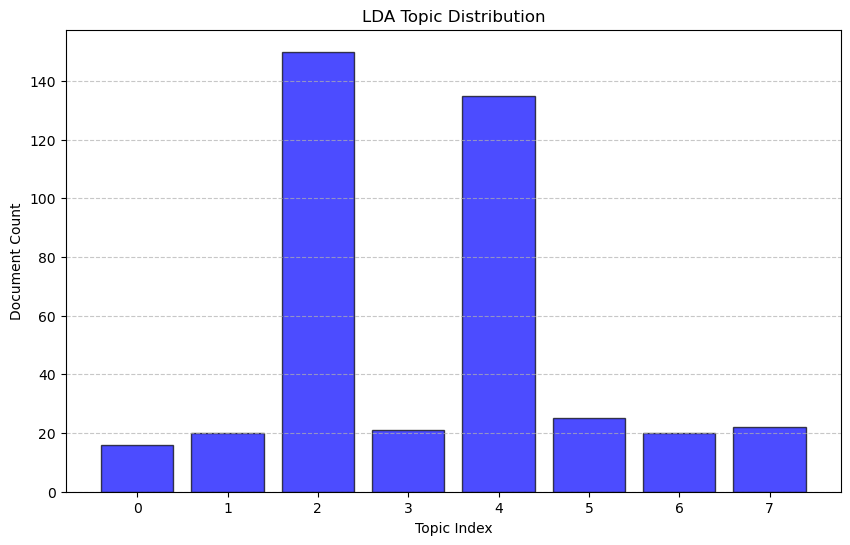

<Figure size 1200x600 with 0 Axes>

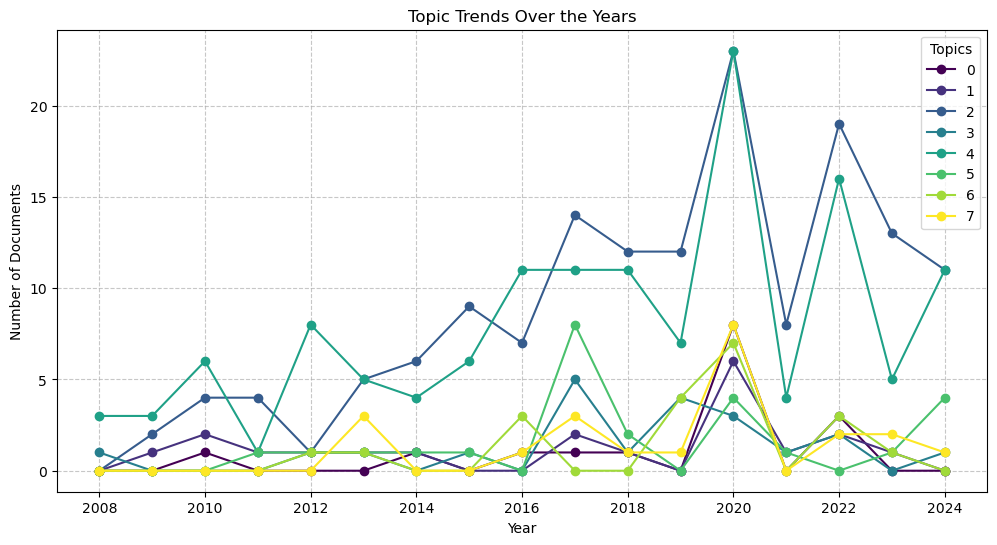


Topic 0: Top 5 Documents
Document ID: 274
Document ID: 247
Document ID: 240
Document ID: 275
Document ID: 269

Topic 1: Top 5 Documents
Document ID: 261
Document ID: 50
Document ID: 180
Document ID: 179
Document ID: 86

Topic 2: Top 5 Documents
Document ID: 20
Document ID: 197
Document ID: 177
Document ID: 81
Document ID: 244

Topic 3: Top 5 Documents
Document ID: 239
Document ID: 212
Document ID: 117
Document ID: 111
Document ID: 262

Topic 4: Top 5 Documents
Document ID: 88
Document ID: 8
Document ID: 51
Document ID: 166
Document ID: 27

Topic 5: Top 5 Documents
Document ID: 75
Document ID: 157
Document ID: 271
Document ID: 89
Document ID: 347

Topic 6: Top 5 Documents
Document ID: 290
Document ID: 297
Document ID: 299
Document ID: 298
Document ID: 282

Topic 7: Top 5 Documents
Document ID: 230
Document ID: 246
Document ID: 259
Document ID: 279
Document ID: 277


<Figure size 1200x600 with 0 Axes>

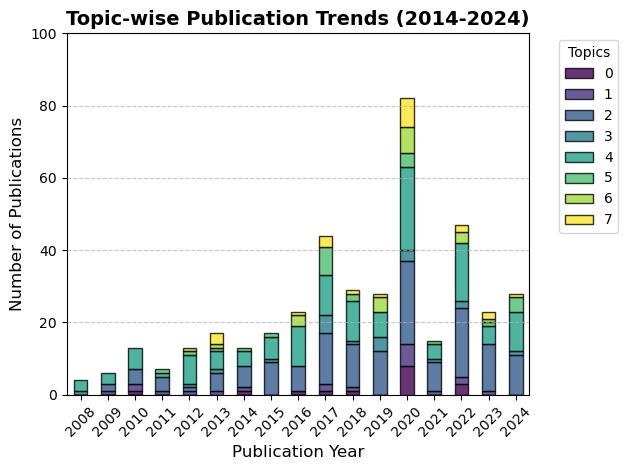

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

# 최적 토픽을 사용한 LDA 모델 학습
lda_model = LdaModel(
    corpus=corpus, 
    num_topics=optimal_topics, 
    id2word=id2word,
    random_state=00,
    chunksize=300,
    passes=10, #20
    iterations=800,
    alpha=0.1,
    eta=0.05,
    minimum_probability=0.005,
    gamma_threshold=0.01
)

# 토픽별 주요 단어 출력
def show_topics(model, num_words=10):
    topics = model.show_topics(num_topics=optimal_topics, num_words=num_words, formatted=False)
    for topic_id, words in topics:
        print(f"Topic {topic_id}: ", [word[0] for word in words])

show_topics(lda_model)

# 📌 LDA 토픽 시각화
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
pyLDAvis.display(vis)
pyLDAvis.save_html(vis, 'lda_vis.html')

vis

# 문서별 주요 토픽 할당
major_topics = [max(lda_model.get_document_topics(doc), key=lambda x: x[1])[0] for doc in corpus]
topic_counts = Counter(major_topics)

# 토픽 분포 시각화
plt.figure(figsize=(10, 6))
plt.bar(topic_counts.keys(), topic_counts.values(), color='blue', alpha=0.7, edgecolor='black')
plt.xlabel('Topic Index')
plt.ylabel('Document Count')
plt.title('LDA Topic Distribution')
plt.xticks(range(optimal_topics))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 📌 토픽별 연도에 따른 주요 문서 변화 그래프
document_years = documents['Publication_Year'].tolist()
df_topics = pd.DataFrame({'Year': document_years[:len(major_topics)], 'Topic': major_topics})
df_topic_trends = df_topics.groupby(['Year', 'Topic']).size().unstack().fillna(0)

plt.figure(figsize=(12, 6))
df_topic_trends.plot(kind='line', marker='o', colormap='viridis', figsize=(12, 6))
plt.xlabel('Year')
plt.ylabel('Number of Documents')
plt.title('Topic Trends Over the Years')
plt.legend(title='Topics')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# 토픽별 주요 문서 확인 (IDM 기반)
def get_top_documents_per_topic(model, corpus, num_docs=5):
    topic_docs = {i: [] for i in range(optimal_topics)}
    for doc_id, doc in enumerate(corpus):
        topics = model.get_document_topics(doc)
        dominant_topic = max(topics, key=lambda x: x[1])[0]
        topic_docs[dominant_topic].append((doc_id, topics))
    
    for topic, docs in topic_docs.items():
        print(f"\nTopic {topic}: Top {num_docs} Documents")
        for doc_id, _ in sorted(docs, key=lambda x: -max([t[1] for t in x[1]]))[:num_docs]:
            print(f"Document ID: {doc_id}")

get_top_documents_per_topic(lda_model, corpus)

# 📌 토픽별 논문 건수 변화 그래프 (2014~2024)
plt.figure(figsize=(12, 6))
df_topic_trends.plot(kind='bar', stacked=True, colormap='viridis', edgecolor='black', alpha=0.8)

plt.xlabel("Publication Year", fontsize=12)
plt.ylabel("Number of Publications", fontsize=12)
plt.title("Topic-wise Publication Trends (2014-2024)", fontsize=14, fontweight='bold')

plt.xticks(rotation=45)
plt.ylim(0, 100)
plt.legend(title="Topics", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [28]:
vis 

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.013620  0.000791       1        1  35.137734
4      0.023300  0.054161       2        1  27.777448
7     -0.099514  0.171631       3        1   7.130960
1      0.146847 -0.031025       4        1   6.814112
5      0.147715 -0.151108       5        1   6.532952
3      0.093401  0.016389       6        1   6.338661
6     -0.276257 -0.168021       7        1   5.859090
0     -0.049113  0.107181       8        1   4.409043, topic_info=           Term        Freq       Total Category  logprob  loglift
4           bim  931.000000  931.000000  Default  30.0000  30.0000
289        city  281.000000  281.000000  Default  29.0000  29.0000
902      energy  193.000000  193.000000  Default  28.0000  28.0000
156  management  378.000000  378.000000  Default  27.0000  27.0000
11        datum  722.000000  722.000000  Default  26.0000  26.0000
..          ...         ...         ...      ...      ...      ...
378      domain   10.760468   57.788850   Topic8  -5.1866   1.4406
187      system   12.312596  394.919714   Topic8  -5.0519  -0.3465
318     support   10.911885   99.725545   Topic8  -5.1726   0.9089
196        type   10.576407   54.024674   Topic8  -5.2039   1.4907
71    efficient   10.302867   64.052325   Topic8  -5.2301   1.2942

[577 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
2349      1  1.007689  academic
2557      3  0.950282  actively
414       1  0.297255       add
414       3  0.713411       add
2151      1  0.277652    aerial
...     ...       ...       ...
797       1  0.339218     world
797       2  0.287031     world
797       5  0.026094     world
797       6  0.339218     world
1515      1  0.974749      zone

[1142 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 8, 2, 6, 4, 7, 1])